In [1]:
import gaussianfunctions as gf
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity

In [2]:
PATH = '<PATH/TO/DIR>/WAVE/Fig3AC_FigS2GI_Molecular_counting/Standard_candles/'

In [3]:
def GassianFitting(all_images, threshold,track,width):
    """
    Fit each puncta with a 2D Gaussian curve.
 
    Parameters
    ----------
    all_images: array
        image stacks
    threshold: int
        threshold for segmentating the puncta
    track: DataFrame
        containing the centroid of each punta and tracking info  
    width: int
        halflength of the bounding box of each puncta
    
    Returns
    -------
    t: DataFrame
        Add all gaussian fitting parameters to the input Dataframe track.
    """
    ratio = 1.0
    sigma = 5 
    t = track
    params = []
    t['amp'],t['sigma_x'],t['sigma_y'],t['signal'],t['offset'],t['center_x'],t['center_y'],t['error'] = \
    [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    for f in range(0,all_images.shape[0]):
        try:
            current = t[t.frame == f]
            image = all_images[f]
            start = current.index[0]
            stop = current.index[-1]
            for r in range(start,stop+1):
                x_pos,y_pos = current.loc[r].y, current.loc[r].x
                if y_pos >width*2 and x_pos > width*2:
                    y_min = int(y_pos - width)
                    y_max = int(y_pos + width)
                    x_min = int(x_pos - width)
                    x_max = int(x_pos + width)
                    local_data = image[x_min:x_max, y_min:y_max]
                    y_min_global = int(y_pos - width*2)
                    y_max_global = int(y_pos + width*2)
                    x_min_global = int(x_pos - width*2)
                    x_max_global = int(x_pos + width*2)
                    local_data_global = image[x_min_global:x_max_global, y_min_global:y_max_global]
                    off_guess = np.mean(local_data_global[local_data_global<threshold]) ##Guess offset of gaussian to be mean background value
#                     print(off_guess)
#                     plt.imshow(local_data)
#                     plt.show()
                    height_low_bound = (ratio * off_guess) - off_guess; ##Set lower bound of gaussian height to be 'ratio' fold above background
                    local_max_value = np.max(local_data)
                    amp_guess = local_max_value - off_guess; ##Guess height of gaussian to be max pixel value minus median pixel value
                    gauss_y_guess, gauss_x_guess = np.unravel_index(local_data.argmax(), local_data.shape) ##Get gaussian location guess with refined coordinates
                    initial_guess = (amp_guess, gauss_x_guess, gauss_y_guess, 1.0, 1.0, off_guess)
                    bound_tup = ([height_low_bound, 1, 1, 0, 0, 0], [+np.Inf, width*2-2, width*2-2, sigma, sigma, +np.Inf])
                    x_local_gauss = np.linspace(0, width*2 - 1, width*2)
                    y_local_gauss = np.linspace(0, width*2 - 1, width*2)
                    x_local_gauss,y_local_gauss = np.meshgrid(x_local_gauss, y_local_gauss)
                    param = gf.fit(gf.func, (x_local_gauss,y_local_gauss), local_data, initial_guess, bound_tup)
                    t.at[r,'amp'],t.at[r,'sigma_x'],t.at[r,'sigma_y'],t.at[r,'signal'],t.at[r,'offset'],t.at[r,'center_x'],t.at[r,'center_y'] = \
                    [param.amp, param.sigma_x, param.sigma_y, param.signal, param.offset, param.center_x, param.center_y]
#                     print(param.offset,param.signal)
                    try:
                        t.at[r,'error'] = param.error[0]
#                         print(param.error[0]/param.amp)
                    except TypeError:
                        t.at[r,'error'] = np.nan
                    except ValueError:
                        t.at[r,'error'] = np.nan
        except IndexError:
            pass
    return t

    

In [4]:
def pickSpots(image, sigma,threshold,min_size, max_size,plot = False):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    threshold: float
         threshold used for segmentation
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    """
    
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    cell_mask_clean = morphology.remove_small_objects(cell_mask, min_size)
    cell_mask_clean = morphology.remove_small_holes(cell_mask_clean, min_size)
    label_mask = measure.label(cell_mask_clean)
    region_properties = measure.regionprops(label_mask)
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area > max_size:
            label_mask_clean[label_mask_clean == r.label] = 0

    closed = morphology.diameter_closing(label_mask_clean, diameter_threshold=50)
    remove_vals = np.unique(closed[closed != label_mask_clean])
    for val in remove_vals:
        label_mask_clean *= label_mask_clean != val

    region_properties = measure.regionprops(label_mask_clean)
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(smooth,vmax = 400)
        plt.contour(label_mask_clean,colors = 'red')
        plt.show()
    return region_properties

In [5]:
def combineResults(filtered,amp_min,amp_max,count):
    """
    Filter the puncta by amplitude and occurance in the image stack.
 
    Parameters
    ----------
    filtered: DataFrame
        Nan removed in puncta info
    amp_min: float
        minimum amplitude threshold 
    amp_max: float
        maximum amplitude threshold 
    count: int
        minimum occurance of puncta
    
    Returns
    -------
    results: DataFrame
        Filtered punta info for final quantification
    """
    results = []
    filtered = filtered[filtered.amp < amp_max]
    filtered = filtered[filtered.amp > amp_min]
    for i in set(filtered.image):
        temp = filtered[filtered.image == i]
        for num in set(temp.particle):
            current = temp[temp.particle == num]
            if len(current)>=count:
                results.extend([np.mean(current.signal)])
    return results

In [6]:
def kdeEstimation(data,bins,bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.array(data)[:, np.newaxis])
    X_plot = np.linspace(np.min(data), np.max(data), bins)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return log_dens,X_plot

In [7]:
def calResults(image,sigma,threshold,min_size,max_size,width):
    """
    Extract fluorescent candle puncta info
    
    Parameters
    ----------
    image: array
        image stack
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    threshold: int
        threshold used for segmentation
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    width: int
        halflength of the bounding box of each puncta
        
    Returns
    -------
    t: DataFrame
        puncta info after tracking and gaussian fitting
    """
    features = pd.DataFrame()
    for i in range(0,image.shape[0]):
        region_properties = pickSpots(image[i],sigma,threshold,min_size,max_size)  
        for j in range(len(region_properties)):
            features = features.append([{'y': region_properties[j].centroid[0],
                                         'x': region_properties[j].centroid[1],
                                         'frame': i},])
    t = tp.link_df(features,5, memory=2)
    t = t.reset_index()
    t = GassianFitting(image,threshold,t,width)
    return t

In [8]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [9]:
def linear(x, a):
    return a * x

In [10]:
def bleachCorrection(xn,yn,image):
    new_image = image.copy()
    popt, pcov = curve_fit(func, xn,yn,p0 = (1000000,1,20000000) )
    for i in range(1,5):
        new_image[i] = image[i]* func(0, *popt)/func(i, *popt)
    return new_image

# Quantification of puncta

Frame 4: 278 trajectories present.
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError


KeyboardInterrupt: 

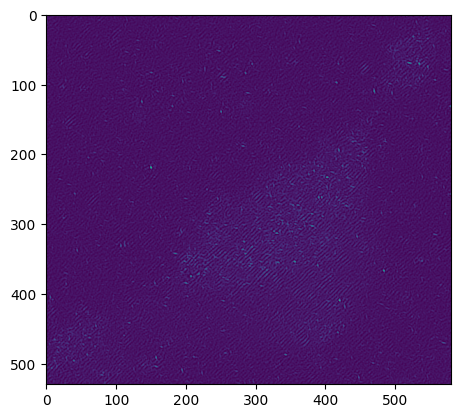

In [11]:
#12mer sim fixed
cut = [(200,500,440,650),(200,400,340,520),(450,800,150,650),(200,500,400,650),\
      (300,650,200,700),(400,700,350,700),(200,600,400,650),(300,650,400,650),\
      (100,480,450,700),(300,680,430,700),(70,600,100,680)]
whole_t_12mer_simfixed = pd.DataFrame()
results = []
for i in range(0,11,1):
    print(i)
    image = io.imread(PATH +'Images/12mer/12mer_'+str(i+1)+'.tif')
    rl, rh, cl, ch = cut[i]
    image = image[:,rl:rh,cl:ch]
    plt.imshow(image[0])
    xn = np.array([0,1,2,3,4])
    yn = np.array([np.sum(image[i]) for i in range(0,5)])
    try:
        image_bc = bleachCorrection(xn,yn,image)
    except RuntimeError:
        image_bc = image
    smooth = filters.gaussian(image_bc,0,preserve_range=True)
    value = filters.threshold_multiotsu(smooth)
    t = calResults(image_bc,0.8,70,1,10,4)
    t['image'] = i
    plt.figure(figsize=(15,15))
    tp.plot_traj(t,superimpose= image_bc[0],label = True)
    plt.show()
    whole_t_12mer_simfixed = whole_t_12mer_simfixed.append(t)
    print(len(whole_t_12mer_simfixed))

Frame 4: 17 trajectories present.


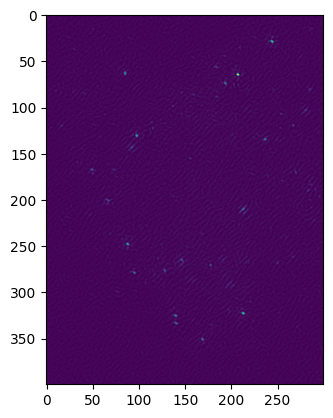

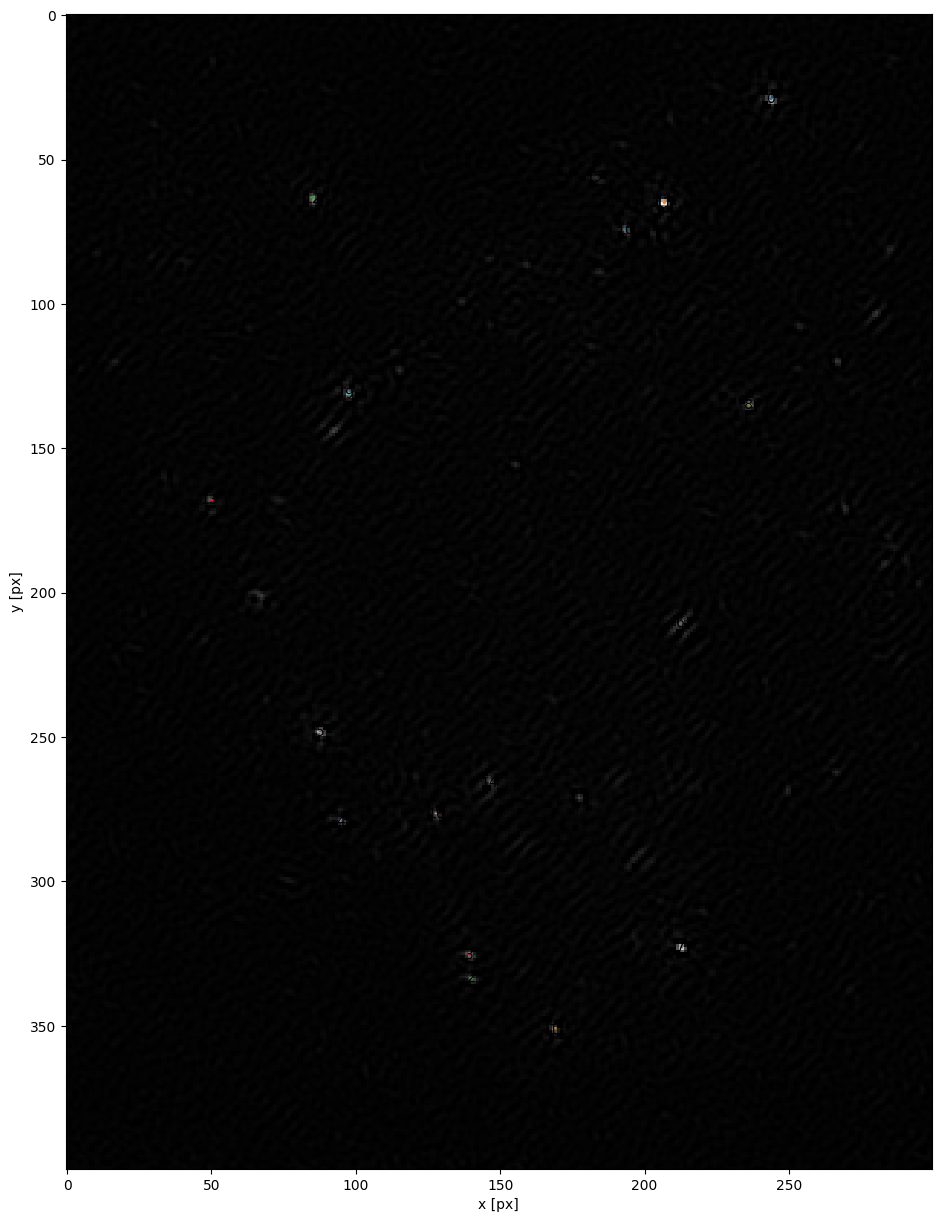

883


/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_64800/900553181.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_t_120mer_simfixed = whole_t_120mer_simfixed.append(t)


In [15]:
#120mer sim fixed
cut = [(400,600,350,700),(550,750,300,600),(400,700,400,650),(200,750,300,700),\
      (300,650,300,550),(400,700,200,800),(350,620,300,650),(450,700,300,650),\
      (380,800,400,800),(250,650,400,700)]
whole_t_120mer_simfixed = pd.DataFrame()
results = []
for i in range(0,10,1):
    print(i)
    image = io.imread(PATH + 'Images/120mer/sim/120mer_'+str(i+1)+'.tif')
    rl, rh, cl, ch = cut[i]
    image = image[:,rl:rh,cl:ch]
    plt.imshow(image[0])
    xn = np.array([0,1,2,3,4])
    yn = np.array([np.sum(image[i]) for i in range(0,5)])
    try:
        image_bc = bleachCorrection(xn,yn,image)
    except RuntimeError:
        image_bc = image
    smooth = filters.gaussian(image_bc,0,preserve_range=True)
    value = filters.threshold_multiotsu(smooth)
    t = calResults(image_bc,0.5,450,2,30,4)
    
    t['image'] = i
    plt.figure(figsize=(15,15))
    tp.plot_traj(t,superimpose= image_bc[0],label = True)
    plt.show()
    whole_t_120mer_simfixed = whole_t_120mer_simfixed.append(t)
    print(len(whole_t_120mer_simfixed))

Frame 4: 17 trajectories present.
ValueError
ValueError
ValueError
ValueError


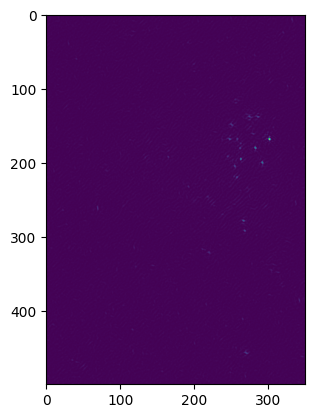

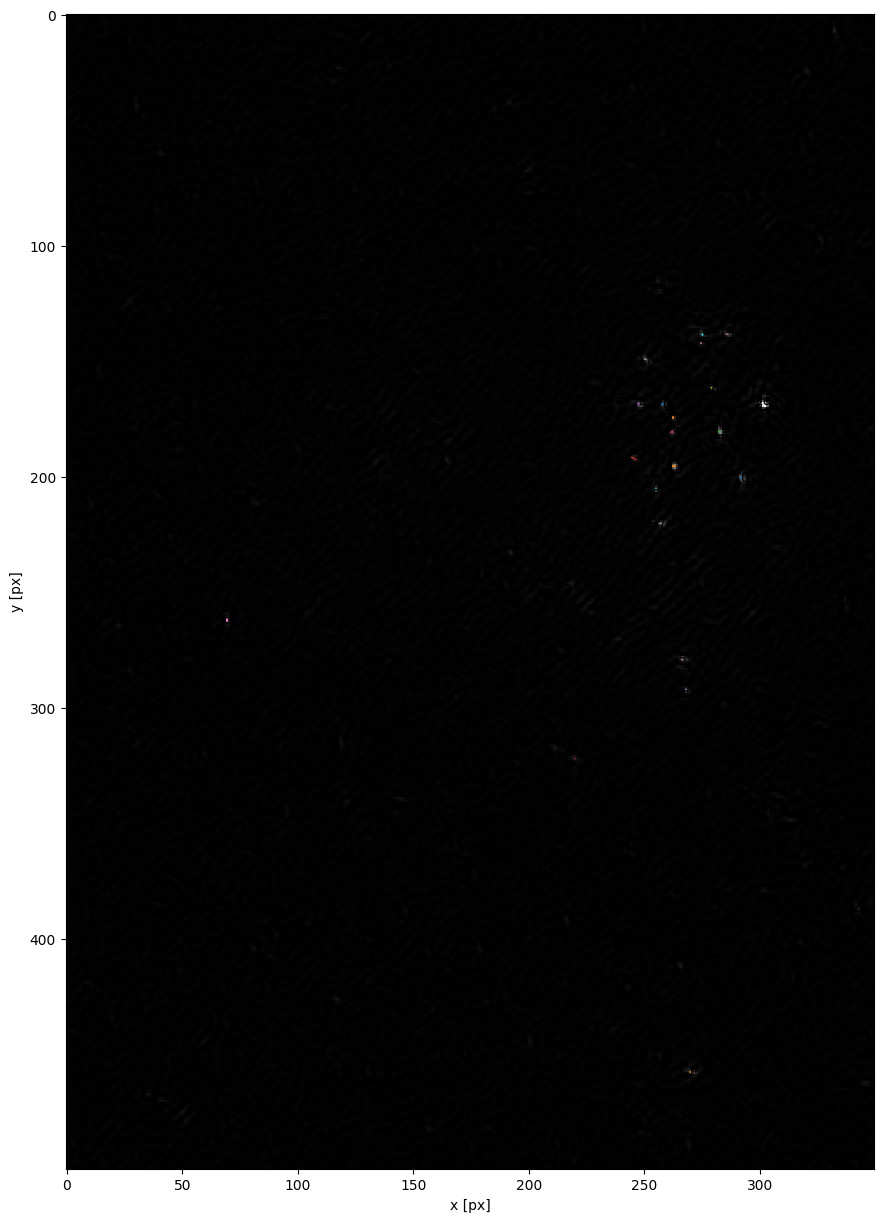

1587


/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_64800/2311177732.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_t_60mer_simfixed = whole_t_60mer_simfixed.append(t)


In [16]:
#60mer sim fixed
cut = [(180,620,340,650),(500,750,350,650),(0,900,200,800),(300,600,350,800),\
       (400,900,400,650),(0,900,50,900),(400,900,400,650),(400,700,300,750),\
       (300,800,200,550)]
whole_t_60mer_simfixed = pd.DataFrame()
results = []
for i in range(0,9,1):
    print(i)
    image = io.imread(PATH + 'Images/60mer/sim/60mer_'+str(i+1)+'.tif')
    rl, rh, cl, ch = cut[i]
    image = image[:,rl:rh,cl:ch]
    plt.imshow(image[0])
    xn = np.array([0,1,2,3,4])
    yn = np.array([np.sum(image[i]) for i in range(0,5)])
    try:
        image_bc = bleachCorrection(xn,yn,image)
    except RuntimeError:
        image_bc = image
    smooth = filters.gaussian(image_bc,0,preserve_range=True)
    value = filters.threshold_multiotsu(smooth)
    t = calResults(image_bc,0.5,220,2,15,4)
    t['image'] = i
    plt.figure(figsize=(15,15))
    tp.plot_traj(t,superimpose= image_bc[0],label = True)
    plt.show()
    whole_t_60mer_simfixed = whole_t_60mer_simfixed.append(t)
    print(len(whole_t_60mer_simfixed))

Frame 4: 21 trajectories present.
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
456.333984375


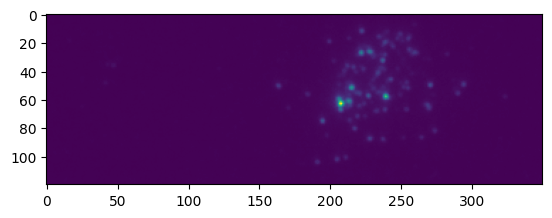

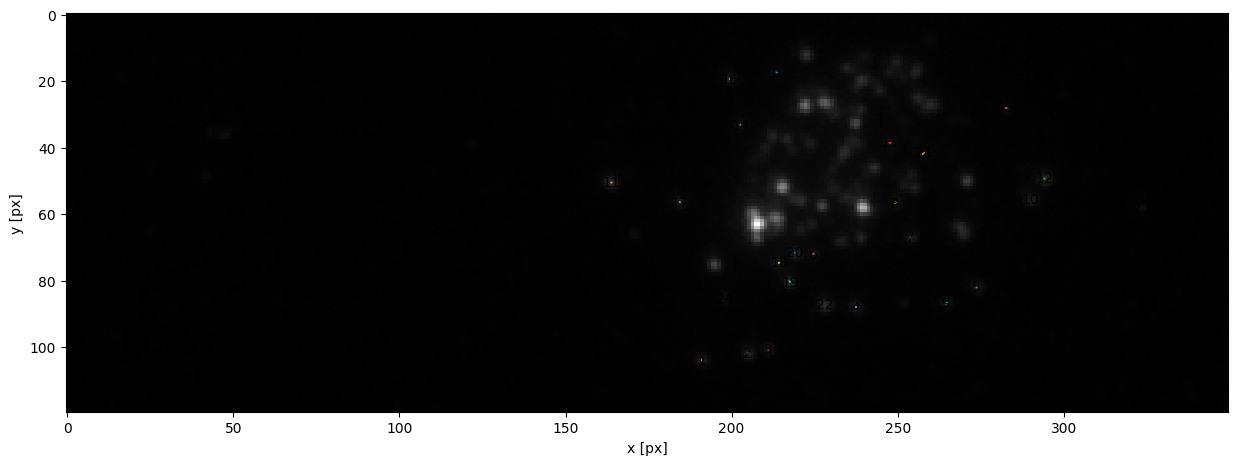

594


/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_64800/1390407218.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_t_60mer_tirf_fixed = whole_t_60mer_tirf_fixed.append(t)


In [17]:
#60mer tirf fixed
cut = [(50,450,50,450), (200,350,150,320),(0,450,0,450),(180,300,180,320),(200,400,180,270),(200,320,50,400)]
num = [1,1,1,1,1,0]
whole_t_60mer_tirf_fixed= pd.DataFrame()
results = []
for i in range(0,6,1):
    print(i)
    image = io.imread(PATH + 'Images/60mer/tirf/fixed/60mer_'+str(i+1)+'.tif')
    rl, rh, cl, ch = cut[i]
    image = image[:,rl:rh,cl:ch]
    plt.imshow(image[0])
    xn = np.array([0,1,2,3,4])
    yn = np.array([np.sum(image[i]) for i in range(0,5)])
    try:
        image_bc = bleachCorrection(xn,yn,image)
    except RuntimeError:
        image_bc = image
    smooth = filters.gaussian(image_bc,0,preserve_range=True)
    value = filters.threshold_multiotsu(smooth)
    print(value[num[i]])
    t = calResults(image_bc,0.5,value[num[i]],2,20,5)
    print(value[num[i]])
    t['image'] = i
    plt.figure(figsize=(15,15))
    tp.plot_traj(t,superimpose= image_bc[0],label = True)
    plt.show()
    whole_t_60mer_tirf_fixed = whole_t_60mer_tirf_fixed.append(t)
    print(len(whole_t_60mer_tirf_fixed))


Frame 4: 31 trajectories present.
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError


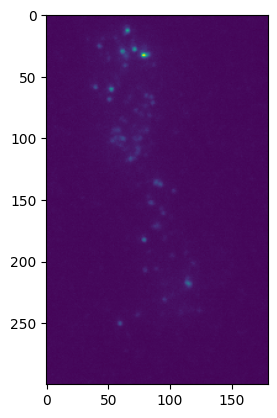

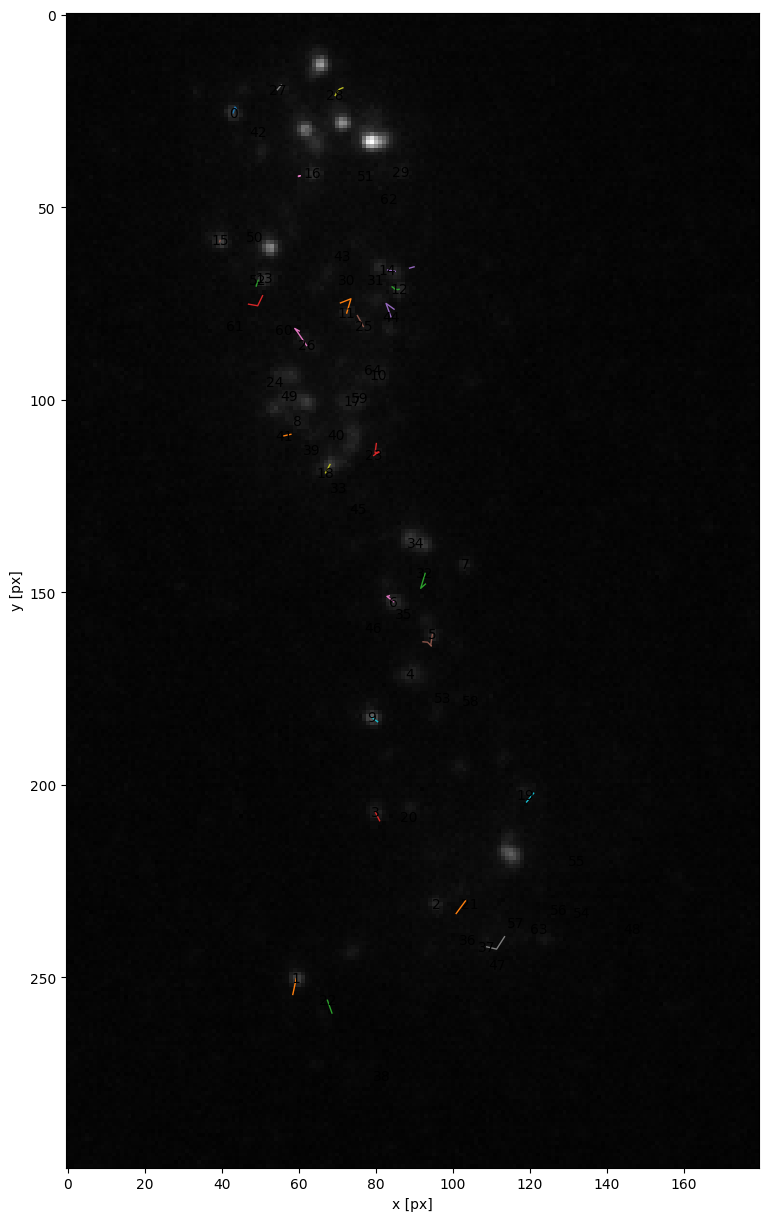

871


/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_64800/3318560221.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_t_60mer_tirf_unfixed = whole_t_60mer_tirf_unfixed.append(t)


In [18]:
#60mer tirf unfixed 
cut = [(100,350,100,450),(150,450,190,400),(150,350,150,320),(150,250,250,400),\
       (120,230,150,350),(220,350,200,350),(100,450,70,400),(200,500,220,400)]
num = [80,90,100,50,-80,80,0,100]
whole_t_60mer_tirf_unfixed = pd.DataFrame()
results = []
for i in range(0,8,1):
    print(i)
    image = io.imread(PATH + 'Images/60mer/tirf/unfixed/60mer_'+str(i+1)+'.tif')
    rl, rh, cl, ch = cut[i]
    image = image[:,rl:rh,cl:ch]
    plt.imshow(image[0])
    xn = np.array([0,1,2,3,4])
    yn = np.array([np.sum(image[i]) for i in range(0,5)])
    try:
        image_bc = bleachCorrection(xn,yn,image)
    except RuntimeError:
        image_bc = image
    smooth = filters.gaussian(image_bc,0,preserve_range=True)
    value = filters.threshold_multiotsu(smooth)
    print(value[0])
    t = calResults(image_bc,0.5,value[0]+num[i],2,20,5)
    t['image'] = i
    plt.figure(figsize=(15,15))
    tp.plot_traj(t,superimpose= image_bc[0],label = True)
    plt.show()
    whole_t_60mer_tirf_unfixed = whole_t_60mer_tirf_unfixed.append(t)
    print(len(whole_t_60mer_tirf_unfixed))

Frame 4: 1 trajectories present.


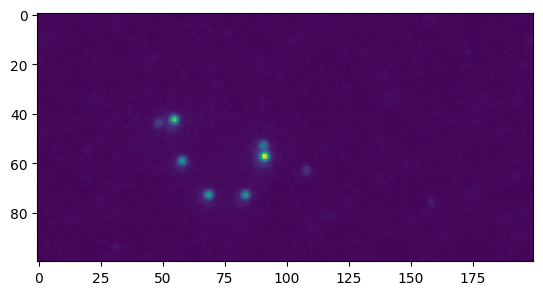

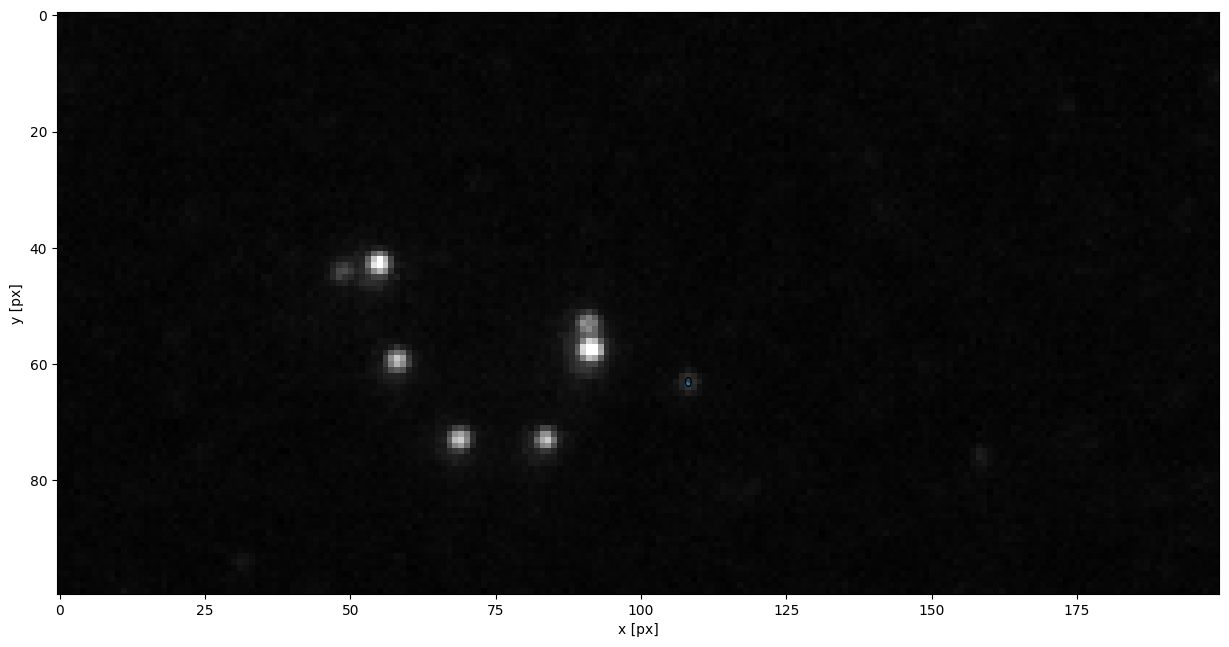

107


/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_64800/546330252.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_t_120mer_tirf_unfixed = whole_t_120mer_tirf_unfixed.append(t)


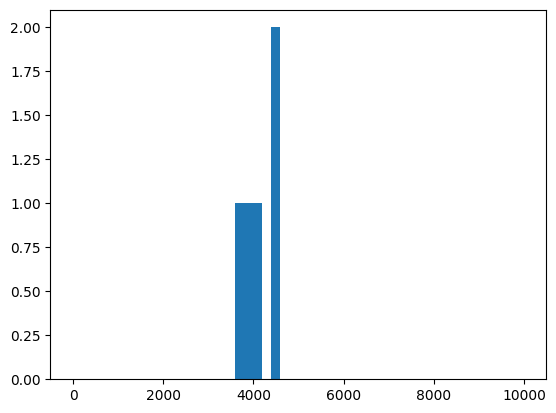

In [19]:
#120mer tirf unfixed 
cut = [(160,400,200,350),(220,320,180,280),(150,320,150,350),(180,300,200,320),\
       (230,350,180,300),(200,300,150,350)]
whole_t_120mer_tirf_unfixed = pd.DataFrame()
results = []
for i in range(0,6,1):
    print(i)
    image = io.imread(PATH + 'Images/120mer/tirf/unfixed/120mer_'+str(i+1)+'.tif')
    rl, rh, cl, ch = cut[i]
    image = image[:,rl:rh,cl:ch]
    plt.imshow(image[0])
    xn = np.array([0,1,2,3,4])
    yn = np.array([np.sum(image[i]) for i in range(0,5)])
    try:
        image_bc = bleachCorrection(xn,yn,image)
    except RuntimeError:
        image_bc = image
    smooth = filters.gaussian(image_bc,0,preserve_range=True)
    value = filters.threshold_multiotsu(smooth)
    print(value[0])
    t = calResults(image_bc,0.8,300,1,20,5)
    t['image'] = i
    plt.figure(figsize=(15,15))
    tp.plot_traj(t,superimpose= image_bc[0],label = True,vmax= 2000)
    plt.show()
    whole_t_120mer_tirf_unfixed = whole_t_120mer_tirf_unfixed.append(t)
    plt.hist(t.signal,bins = 50,range= (0,10000))
    print(len(whole_t_120mer_tirf_unfixed))

Frame 4: 5 trajectories present.
296.03515625


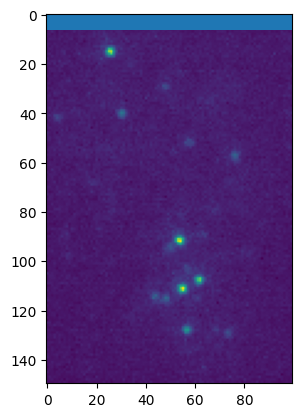

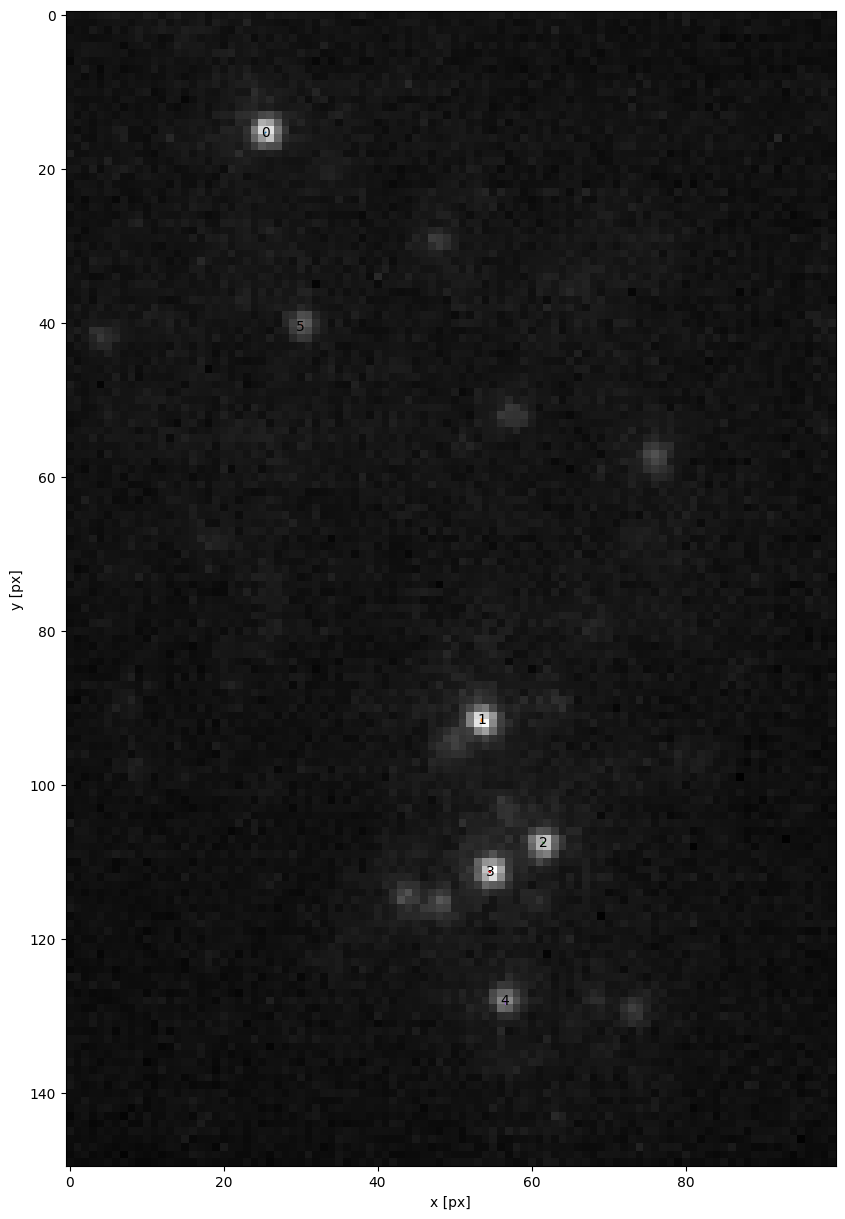

182


/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_64800/162078305.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_t_120mer_tirf_fixed = whole_t_120mer_tirf_fixed.append(t)


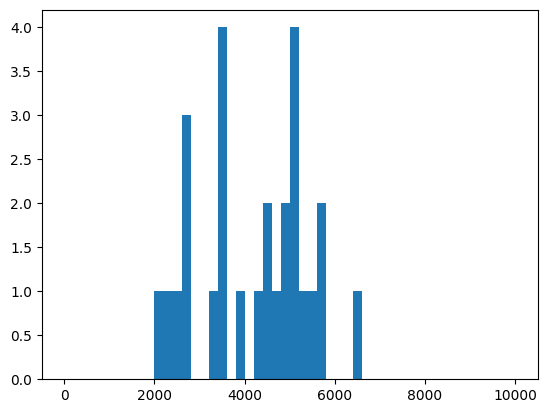

In [20]:
#120mer tirf fixed
cut = [(130,300,170,350),(240,380,150,280),(280,380,200,350),\
       (100,380,150,350),(150,350,150,300),(200,350,200,300),(200,350,200,300)]
num = [0,1,0,1,1,1,1]
whole_t_120mer_tirf_fixed = pd.DataFrame()
results = []
for i in range(0,7,1):
    print(i)
    image = io.imread(PATH + 'Images/120mer/tirf/fixed/120mer_'+str(i+1)+'.tif')
    rl, rh, cl, ch = cut[i]
    image = image[:,rl:rh,cl:ch]
    plt.imshow(image[0])
    xn = np.array([0,1,2,3,4])
    yn = np.array([np.sum(image[i]) for i in range(0,5)])
    try:
        image_bc = bleachCorrection(xn,yn,image)
    except RuntimeError:
        image_bc = image
    smooth = filters.gaussian(image_bc,0,preserve_range=True)
    value = filters.threshold_multiotsu(smooth)
    print(value[0])
    t = calResults(image_bc,0.8,300,1,20,5)
    print(value[num[i]])
    t['image'] = i
    plt.figure(figsize=(15,15))
    tp.plot_traj(t,superimpose= image_bc[0],label = True)
    plt.show()
    whole_t_120mer_tirf_fixed = whole_t_120mer_tirf_fixed.append(t)
    plt.hist(t.signal,bins = 50,range= (0,10000))
    print(len(whole_t_120mer_tirf_fixed))

In [21]:
# Filter and save punta info dataframes to files
filtered = whole_t_12mer_simfixed[np.isnan(whole_t_12mer_simfixed.error) == False]
filtered = filtered[filtered.error/filtered.amp<0.3]
distribution = combineResults(filtered,0,110,3)
pd.DataFrame(distribution).to_csv(PATH + "csv_data/SIM_for_plotting/12mer.csv")
filtered = whole_t_60mer_simfixed[np.isnan(whole_t_60mer_simfixed.error) == False]
filtered = filtered[filtered.error/filtered.amp<0.15]
distribution = combineResults(filtered,0,550,3)
pd.DataFrame(distribution).to_csv(PATH + "csv_data/SIM_for_plotting/60mer.csv")
filtered = whole_t_120mer_simfixed[np.isnan(whole_t_120mer_simfixed.error) == False]
filtered = filtered[filtered.error/filtered.amp<0.15]
# filtered = filtered[filtered.amp>=500]
distribution = combineResults(filtered,0,1100,3)
pd.DataFrame(distribution).to_csv(PATH + "csv_data/SIM_for_plotting/120mer.csv")
filtered = whole_t_60mer_tirf_fixed[np.isnan(whole_t_60mer_tirf_fixed.error) == False]
filtered = filtered[filtered.error/filtered.amp<0.15]
distribution = combineResults(filtered,0,350,2)
pd.DataFrame(distribution).to_csv(PATH +"csv_data/TIRF_fixed_vs_unfixed/60mer_tirf_fixed.csv")
filtered = whole_t_60mer_tirf_unfixed[np.isnan(whole_t_60mer_tirf_unfixed.error) == False]
filtered = filtered[filtered.error/filtered.amp<0.15]
distribution = combineResults(filtered,0,350,2)
pd.DataFrame(distribution).to_csv(PATH + "csv_data/TIRF_fixed_vs_unfixed/60mer_tirf_unfixed.csv")
filtered = whole_t_120mer_tirf_fixed[np.isnan(whole_t_120mer_tirf_fixed.error) == False]
filtered = filtered[filtered.error/filtered.amp<0.15]
distribution = combineResults(filtered,100,800,2)
pd.DataFrame(distribution).to_csv(PATH + "csv_data/TIRF_fixed_vs_unfixed/120mer_tirf_fixed.csv")
filtered = whole_t_120mer_tirf_unfixed[np.isnan(whole_t_120mer_tirf_unfixed.error) == False]
filtered = filtered[filtered.error/filtered.amp<0.15]
distribution = combineResults(filtered,100,800,1)
pd.DataFrame(distribution).to_csv(PATH + "csv_data/TIRF_fixed_vs_unfixed/120mer_tirf_unfixed.csv")

# Generate plots

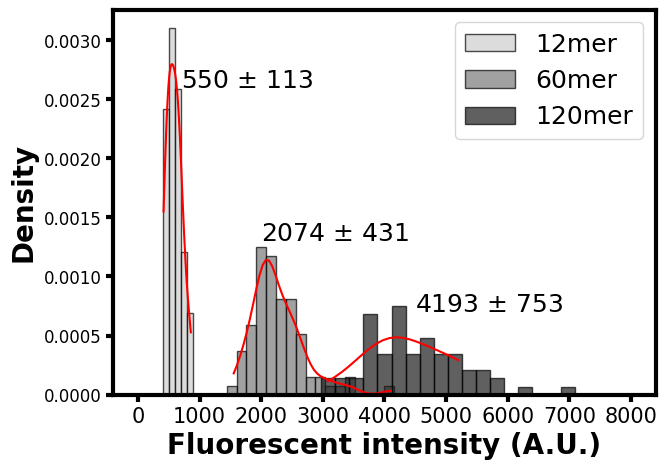

In [15]:
# Fig. 3A middle panel
# Histagram of standard candle fluorscent quantification

fig,ax = plt.subplots(figsize = (7,5))
greys = matplotlib.cm.get_cmap('Greys')
distribution = pd.read_csv(PATH + 'csv_data/SIM_for_plotting/12mer.csv',index_col=0)
distribution = np.array(distribution.iloc[:,0])
std_12mer = np.std(distribution)
bins = 80
bandwidth = 70
log_dens,X_plot = kdeEstimation(distribution,bins,bandwidth)
plt.hist(distribution,bins =bins,density = True,range = (0,8000),alpha = 0.7,histtype='bar', ec='black',color= greys(0.3),label = '12mer')
plt.plot(X_plot[:, 0], np.exp(log_dens),'-',color = 'red',)
mode_12mer = X_plot[log_dens.argmax()]
plt.text(700,0.0026,"{} $\pm$ {}".format(int(mode_12mer),int(std_12mer)),size = 18)
distribution = pd.read_csv(PATH + 'csv_data/SIM_for_plotting/60mer.csv',index_col=0)
distribution = np.array(distribution.iloc[:,0])
std_60mer = np.std(distribution)
bins = 50
bandwidth = 150
log_dens,X_plot = kdeEstimation(distribution,bins,bandwidth)
plt.hist(distribution,bins =bins,density =True,range = (0,8000),alpha = 0.7,histtype='bar', ec='black',color= greys(0.6),label = '60mer')
plt.plot(X_plot[:, 0], np.exp(log_dens),'-',color = 'red',)
mode_60mer = X_plot[log_dens.argmax()]
plt.text(2000,0.0013,"{} $\pm$ {}".format(int(mode_60mer),int(std_60mer)),size = 18)
distribution = pd.read_csv(PATH + 'csv_data/SIM_for_plotting/120mer.csv',index_col=0)
distribution = np.array(distribution.iloc[:,0])
std_120mer = np.std(distribution)
bins = 35
bandwidth = 400
log_dens,X_plot = kdeEstimation(distribution,bins,bandwidth)
plt.hist(distribution,bins =bins,density = True,range = (0,8000),alpha = 0.7,histtype='bar', ec='black',color= greys(0.9),label = '120mer')
plt.plot(X_plot[:20, 0], np.exp(log_dens)[:20],'-',color = 'red',)
mode_120mer = X_plot[log_dens.argmax()]
plt.text(4500,0.0007,"{} $\pm$ {}".format(int(mode_120mer),int(std_120mer)),size = 18)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.xlabel('Fluorescent intensity (A.U.)',size = 20,fontweight = 'bold')
plt.ylabel('Density',size = 20,fontweight = 'bold')
plt.xticks(size = 15)
plt.yticks(size = 12)
plt.legend(loc ='upper right',fontsize = 18)
plt.savefig(PATH + "result_figures/Fig4B_distribution.png",bbox_inches = 'tight',dpi = 300)

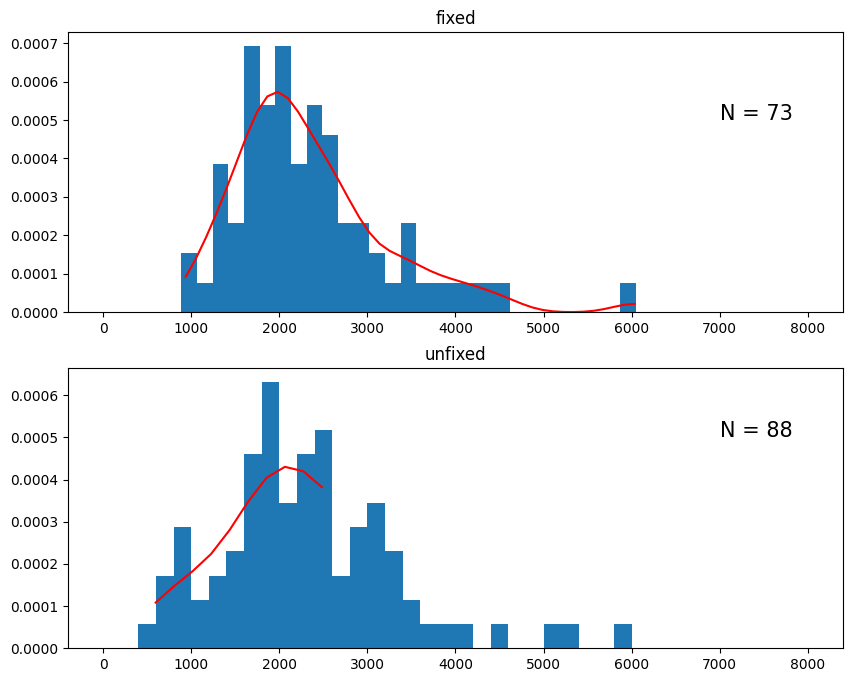

In [13]:
# Fixed vs. unfixed 60mer
fig, axs = plt.subplots(2,figsize = (10,8))
distribution = pd.read_csv(PATH + 'csv_data/TIRF_fixed_vs_unfixed/60mer_tirf_fixed.csv',index_col = 0)
distribution = np.array(distribution.iloc[:,0])
bins = 45
bandwidth = 250
log_dens,X_plot = kdeEstimation(distribution,bins,bandwidth)
axs[0].hist(distribution,bins =bins,density = True,range = (0,8000))
axs[0].plot(X_plot[:, 0], np.exp(log_dens),'-',color = 'red',)
axs[0].text(7000,0.0005,"N = " + str(len(distribution)),size = 15)
axs[0].set_title('fixed')
mode_60mer_fixed = X_plot[log_dens.argmax()]
std_60mer_fixed = np.std(distribution)
distribution = pd.read_csv(PATH + 'csv_data/TIRF_fixed_vs_unfixed/60mer_tirf_unfixed.csv',index_col = 0)
distribution = np.array(distribution.iloc[:,0])
bins = 45
bins = 40
bandwidth = 400
log_dens,X_plot = kdeEstimation(distribution,bins,bandwidth)
axs[1].hist(distribution,bins =bins,density = True,range = (0,8000))
axs[1].plot(X_plot[:10, 0], np.exp(log_dens)[:10],'-',color = 'red',)
axs[1].set_title('unfixed')
axs[1].text(7000,0.0005,"N = " + str(len(distribution)),size = 15)
mode_60mer_unfixed = X_plot[log_dens.argmax()]
std_60mer_unfixed = np.std(distribution)

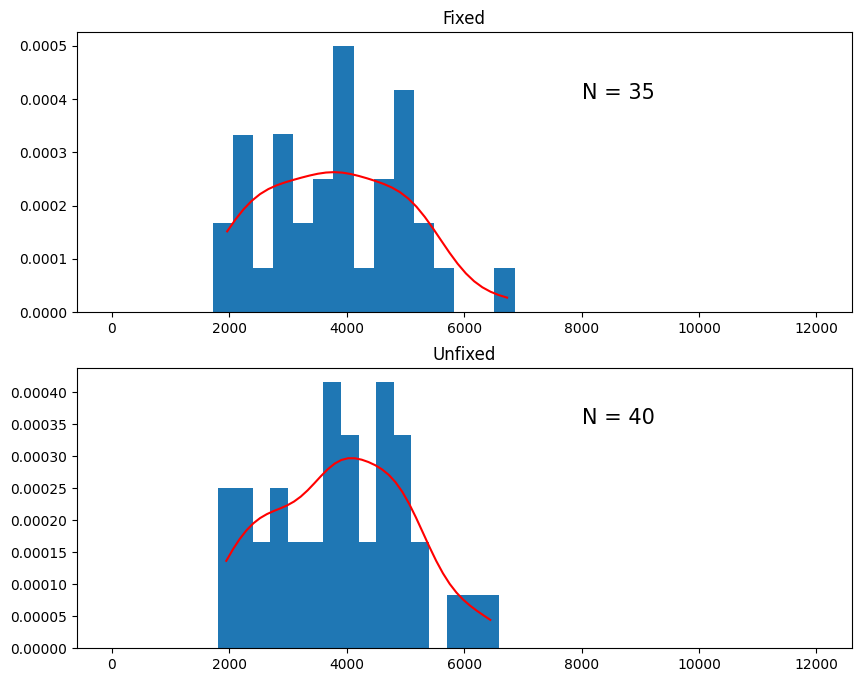

In [14]:
# Fixed vs. unfixed 120mer
fig, axs = plt.subplots(2,figsize = (10,8))
distribution = pd.read_csv(PATH + 'csv_data/TIRF_fixed_vs_unfixed/120mer_tirf_fixed.csv',index_col = 0)
distribution = np.array(distribution.iloc[:,0])
bins = 35
bandwidth = 600
log_dens,X_plot = kdeEstimation(distribution,bins,bandwidth)
axs[0].hist(distribution,bins =bins,density = True,range = (0,12000))
axs[0].plot(X_plot[:, 0], np.exp(log_dens),'-',color = 'red',)
axs[0].set_title('Fixed')
axs[0].text(8000,0.0004,"N = " + str(len(distribution)),size = 15)
mode_120mer_fixed = X_plot[log_dens.argmax()]
std_120mer_fixed = np.std(distribution)
distribution = pd.read_csv(PATH + 'csv_data/TIRF_fixed_vs_unfixed/120mer_tirf_unfixed.csv',index_col = 0)
distribution = np.array(distribution.iloc[:,0])
bins = 40
bandwidth = 500
log_dens,X_plot = kdeEstimation(distribution,bins,bandwidth)
axs[1].hist(distribution,bins =bins,density = True,range = (0,12000))
axs[1].plot(X_plot[:60, 0], np.exp(log_dens)[:60],'-',color = 'red',)
axs[1].text(8000,0.00035,"N = " + str(len(distribution)),size = 15)
axs[1].set_title('Unfixed')
mode_120mer_unfixed = X_plot[log_dens.argmax()]
std_120mer_unfixed = np.std(distribution)

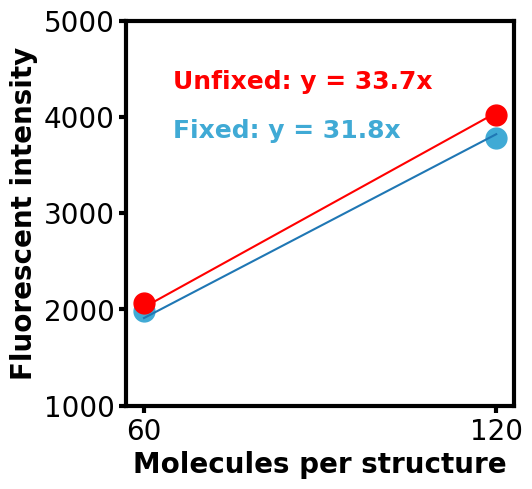

In [16]:
# Fig. S3 A
# Correction for fluorscent loss after fixation
_,ax = plt.subplots(figsize = (5,5))
xdata = np.array([60,120])
ydata_fixed = np.array([float(mode_60mer_fixed),float(mode_120mer_fixed)])
ydata_unfixed = np.array([float(mode_60mer_unfixed),float(mode_120mer_unfixed)])
popt_fixed, pcov_fixed = curve_fit(linear, xdata, ydata_fixed)
popt_unfixed, pcov_unfixed = curve_fit(linear, xdata, ydata_unfixed)
plt.plot(xdata,ydata_fixed,'o',color = '#40aad5',ms = 15)
plt.plot(xdata,ydata_unfixed,'ro',ms = 15)
plt.plot(xdata, popt_fixed[0]*xdata)
plt.plot(xdata, popt_unfixed[0]*xdata,color = 'Red')
plt.text(65,3500,'Fixed: y = {:.1f}x\n'.format(popt_fixed[0]),size = 18,color = "#40aad5",fontweight = 'bold')
plt.text(65,4000,'Unfixed: y = {:.1f}x\n'.format(popt_unfixed[0]),size = 18,color = "red",fontweight = 'bold')
# plt.legend(fontsize=15)
plt.xlabel("Molecules per structure",size = 20,fontweight = 'bold')
plt.xticks([60,120])
plt.tick_params(labelsize = 12)
plt.yticks([1000,2000,3000,4000,5000])
plt.ylabel("Fluorescent intensity",size = 20,fontweight = 'bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5,labelsize =20)
plt.savefig(PATH + "result_figures/FigS2G_Fix_vs_unfix.png",dpi = 300,bbox_inches='tight')

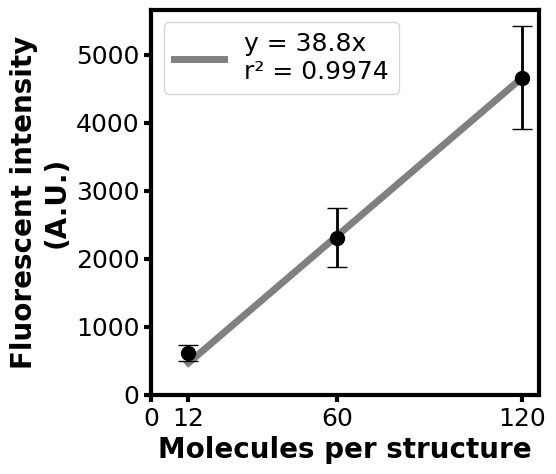

In [17]:
# Fig. 4 A right panel
# Fluorescent standard curve made from candles
_,ax = plt.subplots(figsize = (5,5))
xdata = np.array([12,60,120])
ydata = np.array([float(mode_12mer),float(mode_60mer),float(mode_120mer)])/0.9
popt, pcov = curve_fit(linear, xdata, ydata)
residuals = ydata- linear(xdata,popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
plt.plot(xdata, popt[0]*xdata,label='y = {:.1f}x\nr\u00b2 = {:.4f}'.format(popt[0],r_squared),color ='grey',lw = 5)
# plt.plot(xdata,ydata,'ro',ms = 8,color = 'black')
plt.errorbar(xdata,ydata,yerr= [std_12mer,std_60mer,std_120mer],marker = 'o',ms = 10,color = 'black',capsize = 7,ls = 'none',elinewidth = 2)
plt.legend(fontsize=18)
plt.xlabel("Molecules per structure",size = 20,fontweight = 'bold')
plt.xticks([0,12,60,120])
plt.tick_params(labelsize = 18)
plt.yticks([0,1000,2000,3000,4000,5000])
plt.ylabel("Fluorescent intensity\n(A.U.)",size = 20,fontweight = 'bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.savefig(PATH + 'result_figures/Fig3A_fitting.png',bbox_inches='tight',dpi = 300)